In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

## Step 1: Load data, clean up / process

In [2]:
LOCAL_PATH = '/home/jcbowden/ci_stat256/data/'

In [3]:
%%time 
adata = sc.read_h5ad(LOCAL_PATH+"SCP1064/other/adata.h5ad")
adata.X.data

CPU times: user 927 ms, sys: 4.95 s, total: 5.87 s
Wall time: 15.9 s


array([2., 1., 1., ..., 2., 1., 1.])

In [4]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

In [5]:
(adata.obs["n_genes"] < 500).sum(), (adata.var["n_cells"] < 500).sum()

(304, 8376)

In [6]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=500)

In [7]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)

In [35]:
adata.X # this is the matrix of counts, N by n_genes_measured (total)

<218027x15335 sparse matrix of type '<class 'numpy.float64'>'
	with 739608339 stored elements in Compressed Sparse Row format>

In [8]:
# make sure we can match sgRNAs back to the genes
adata.obs

,library_preparation_protocol,condition,MOI,sgRNA,UMI_count,sgRNAs,n_genes
NAME,,,,,,,
CELL_1,10X 3' v3 sequencing,Control,1,HLA-B_2,10832.0,HLA-B_2,3520
CELL_2,10X 3' v3 sequencing,Control,2,NaN,10731.0,"NGFR_3,SERPINF1_3",3531
CELL_3,10X 3' v3 sequencing,Control,1,HLA-B_2,28821.0,HLA-B_2,5541
CELL_4,10X 3' v3 sequencing,Control,2,NaN,15322.0,"NMRK1_3,S100A6_3",4086
CELL_5,10X 3' v3 sequencing,Control,0,NaN,10314.0,,3178
...,...,...,...,...,...,...,...
CELL_218327,10X 3' v3 sequencing,Co-culture,4,NaN,12722.0,"CTSO_3,PIK3IP1_3,VDAC2_2,WNT7A_1",3686
CELL_218328,10X 3' v3 sequencing,Co-culture,2,NaN,11643.0,"JAK2_3,SLC7A5P1_3",3462
CELL_218329,10X 3' v3 sequencing,Co-culture,3,NaN,12497.0,"S100A6_2,SAT1_2,ONE_NON-GENE_SITE_177",3768


In [9]:
# check if the field MOI has some irregularities, such that a truncated guide or a wrong number
ind = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    flag = False
    if row["sgRNAs"] != "":
        guides = row["sgRNAs"].split(",")
        if len(guides) != row["MOI"]:
            flag = True
        if "_" not in guides[-1]:
            flag = True
    if flag:
        ind += [index]

  0%|          | 0/218027 [00:00<?, ?it/s]

In [10]:
# empty!!
ind

[]

In [11]:
# check gene sets and ensure matching with measurements
err = 0
ind = []
obs_genes = {}
unfound_genes = {}
targets = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    current_target = []
    if row["sgRNAs"] != "":
        # get all guides in cells
        sg = row["sgRNAs"].split(",")
        # get gene name by stripping guide specific info
        sg_genes = [guide.rsplit("_", maxsplit=1)[0] for guide in sg]
        for gene in sg_genes:
            if gene in adata.var.index:
                # gene is found
                current_target += [gene]
                if gene not in obs_genes:
                    obs_genes[gene] = 1
                else:
                    obs_genes[gene] += 1
            else:
                if gene not in unfound_genes:
                    unfound_genes[gene] = 1
                else:
                    unfound_genes[gene] += 1
    # end gene list
    targets += [",".join(current_target)]

  0%|          | 0/218027 [00:00<?, ?it/s]

In [12]:
# create regimes
regimes = np.unique(targets, return_inverse=True)[1]

In [13]:
adata.obs["targets"] = targets
adata.obs["regimes"] = regimes

In [14]:
len(obs_genes.keys())

220

In [15]:
# some leftover genes I couldn't match
unfound_genes.keys()

dict_keys(['NGFR', 'SERPINF1', 'CSPG4', 'PIK3IP1', 'ONE_NON-GENE_SITE', 'NO_SITE', 'NUP50-AS1', 'IDI2-AS1', 'CXCR4', 'JMJD7', 'TYR', 'BOLA2', 'LRRC75A-AS1', 'LINC00518', 'APOD', 'A2M', 'LEF1-AS1', 'SLC7A5P1', 'SERPINA3', 'WNT7A', 'GAS5', 'IRF4', 'APOC2', 'XAGE1A', 'CCND2', 'CDH19', 'ST6GALNAC2', 'S100B', 'HLA-H', 'SNHG6'])

## Step 2: comparing variability of gene expression to guide ID

In [19]:
%%time
sc.pp.highly_variable_genes(adata, layer="counts", flavor='seurat_v3', n_top_genes=3000 , span=0.2)

CPU times: user 19.8 s, sys: 20.9 s, total: 40.7 s
Wall time: 41.2 s


highly variable = "significantly higher variance" -- though this is unclear since you specify how many. 
In reality, it seems like it just picks the `n` (3000 in this case) genes with highest variance (relative to mean), no?
This is the threshold you see in the below plot. 

In general, this is used to identify genes that are
likely interesting in your data since they, well, vary a lot across different "treatments".

In [20]:
adata.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
A1BG,34703,True,1689.0,0.189256,0.232778,1.069112
A1BG-AS1,12461,False,NaN,0.060226,0.063213,0.964280
A4GALT,1537,False,NaN,0.007233,0.007566,0.985149
AAAS,39657,False,NaN,0.213538,0.241693,0.970792
AACS,19249,False,NaN,0.094887,0.099974,0.948419
...,...,...,...,...,...,...
ZXDB,2581,False,NaN,0.011994,0.012162,0.957151
ZXDC,14586,False,NaN,0.070569,0.073387,0.947735
ZYG11B,26023,False,NaN,0.132493,0.144036,0.972143
ZYX,153542,False,NaN,1.634701,3.017341,0.954339


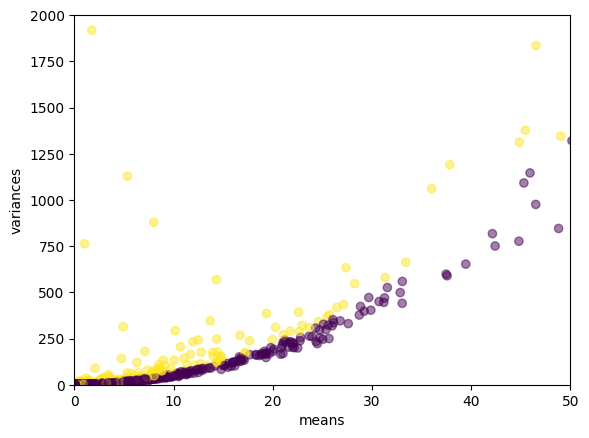

In [37]:
plt.scatter(adata.var["means"], adata.var["variances"], c=adata.var["highly_variable"], alpha=0.5)
plt.xlabel("means")
plt.ylabel("variances")
plt.xlim((0, 50))
plt.ylim((0, 2000))
plt.show()

In [22]:
presence = pd.Series(data=np.zeros_like(adata.var["means"]), index=adata.var.index)
for gene in list(obs_genes.keys()):
    presence[gene] += 1
adata.var["targeted"] = presence # this means there's an sgRNA for it -- not totally sure what it means for it to be targeted, though

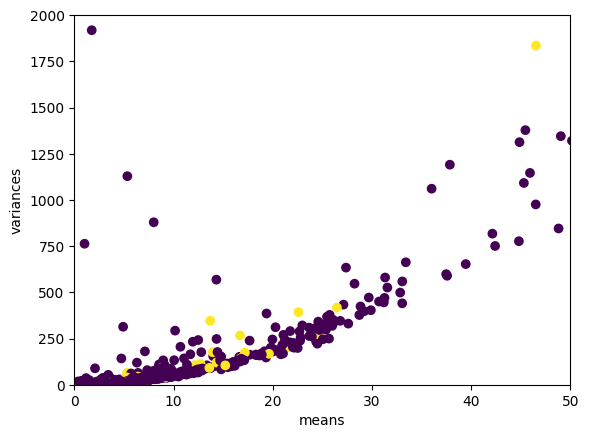

In [23]:
plt.scatter(adata.var["means"], adata.var["variances"], c=adata.var["targeted"])
plt.xlabel("means")
plt.ylabel("variances")
plt.xlim((0, 50))
plt.ylim((0, 2000))
plt.show()

In [24]:
# adata.write_h5ad("SCP1064/other/processed_adata.h5ad")

In [25]:
# out of 3000 highly variable genes, and 250 targeted genes, only 96 is in the intersection
(adata.var["highly_variable"] * adata.var["targeted"]).sum()
# for future reference we probably add all intervened genes and complete with highly variable 

100.0

## Step 3 [optional]: make a small data (subsampling of treatments, as well as gene count readouts)

In [26]:
np.unique(adata.obs.condition.values)

array(['Co-culture', 'Control', 'IFNγ'], dtype=object)

In [27]:
# filter genes (1000)
to_keep = np.logical_or(adata.var["highly_variable_rank"] < 1500, adata.var["targeted"])
adata_gf = adata[:, to_keep].copy()

In [31]:
# filter conditions
adata_gf[adata_gf.obs.condition == "Control"].copy().write_h5ad(LOCAL_PATH+"SCP1064/ready/control/gene_filtered_adata.h5ad")
adata_gf[adata_gf.obs.condition == "Co-culture"].copy().write_h5ad(LOCAL_PATH+"SCP1064/ready/cocult/gene_filtered_adata.h5ad")
adata_gf[adata_gf.obs.condition == "IFNγ"].copy().write_h5ad(LOCAL_PATH+"SCP1064/ready/ifn/gene_filtered_adata.h5ad")

In [32]:
adata_small = adata_gf[np.random.choice(np.arange(adata.n_obs), size=10000, replace=False)].copy()
adata_small.write_h5ad(LOCAL_PATH+"SCP1064/other/small_adata.h5ad")

In [44]:
adata_tiny = adata_gf[np.random.choice(np.arange(adata.n_obs), size=10, replace=False)].copy()
adata_tiny.write_h5ad(LOCAL_PATH+"SCP1064/other/tiny_adata.h5ad")

In [53]:
adata_tiny

AnnData object with n_obs × n_vars = 10 × 1657
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs', 'n_genes', 'targets', 'regimes'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'targeted'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [54]:
adata_tiny.layers['counts']

<10x1657 sparse matrix of type '<class 'numpy.float64'>'
	with 5535 stored elements in Compressed Sparse Row format>

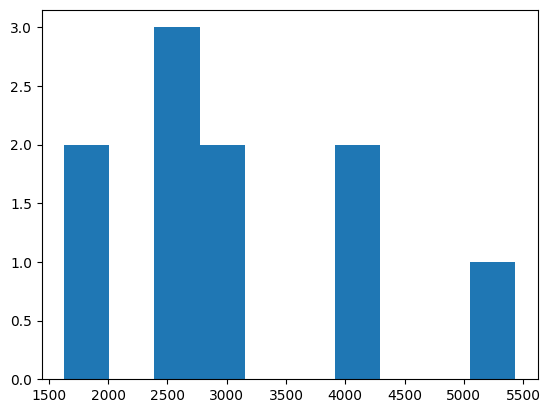

In [56]:
cnts = adata_tiny.layers['counts'].toarray()
plt.hist(cnts.sum(axis=-1)); plt.show()

In [51]:
adata # original (full) data object; note that this doesn't get resaved in this notebook

AnnData object with n_obs × n_vars = 218027 × 15335
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs', 'n_genes', 'targets', 'regimes'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'targeted'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [4]:
%%time 
adata = sc.read_h5ad(LOCAL_PATH+"SCP1064/other/tiny_adata.h5ad")
adata.X.data

CPU times: user 23.3 ms, sys: 2.72 ms, total: 26 ms
Wall time: 37.1 ms


array([2.30243211, 2.30243211, 2.94427794, ..., 3.34920479, 2.31846097,
       2.31846097])

In [6]:
adata.X

<10x1657 sparse matrix of type '<class 'numpy.float64'>'
	with 5535 stored elements in Compressed Sparse Row format>

In [7]:
adata.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,targeted
ABCG2,43098,True,713.0,0.270783,0.412499,1.280399,0.0
ABHD14B,63330,True,1215.0,0.412132,0.593385,1.130482,0.0
ABHD17C,34522,True,638.0,0.206818,0.319366,1.328197,0.0
ABL2,74230,True,1002.0,0.493535,0.760715,1.170876,0.0
AC003092.1,36602,True,324.0,0.237562,0.475413,1.700979,0.0
...,...,...,...,...,...,...,...
ZNF665,2986,True,1287.0,0.014136,0.016789,1.118916,0.0
ZNF676,4255,True,1482.0,0.021282,0.024746,1.091299,0.0
ZNF723,2780,True,1071.0,0.014072,0.017268,1.156160,0.0
ZNF781,4637,True,1155.0,0.023639,0.028695,1.138998,0.0


In [19]:
(adata.var.targeted != 0).sum() # what's difference btwn targeted and sgRNAs? 
# Answer: they're named slightly different things, not 1 to 1. but targets are in adata.var (targeted==1). which I believe means they should be absent.

220

In [20]:
adata.var[adata.var.targeted != 0]

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,targeted
ACSL3,161125,False,NaN,1.733973,3.038900,0.882086,1.0
ACTA2,3754,True,337.0,0.019250,0.034226,1.669910,1.0
AEBP1,37582,True,1704.0,0.210859,0.262286,1.068041,1.0
AGA,63916,False,NaN,0.372876,0.431955,0.925420,1.0
AHCY,127811,True,1496.0,1.205750,2.256406,1.089899,1.0
...,...,...,...,...,...,...,...
UQCRFS1,196461,False,NaN,3.526283,8.305203,0.804852,1.0
UQCRH,216201,False,NaN,13.605379,91.129983,0.849416,1.0
VAT1,118559,True,1354.0,1.055296,1.921199,1.108039,1.0
VDAC2,192268,False,NaN,3.367445,8.727812,0.911353,1.0


In [23]:
adata.var.index[adata.var.index=="CD47"]

Index(['CD47'], dtype='object')

In [24]:
for i, gene in enumerate(adata.var.index):
    print(i, gene)
    break

0 ABCG2


In [8]:
adata.obs

,library_preparation_protocol,condition,MOI,sgRNA,UMI_count,sgRNAs,n_genes,targets,regimes
NAME,,,,,,,,,
CELL_48584,10X 3' v3 sequencing,Control,1,APOD_2,11119.0,APOD_2,3510,,0
CELL_138234,10X 3' v3 sequencing,IFNγ,1,PPIA_1,6278.0,PPIA_1,2348,PPIA,24772
CELL_62035,10X 3' v3 sequencing,IFNγ,1,CD47_3,6996.0,CD47_3,2481,CD47,6995
CELL_59062,10X 3' v3 sequencing,IFNγ,1,ONE_NON-GENE_SITE_217,8089.0,ONE_NON-GENE_SITE_217,2536,,0
CELL_30040,10X 3' v3 sequencing,Control,1,ACSL3_2,15369.0,ACSL3_2,4007,ACSL3,1
CELL_155732,10X 3' v3 sequencing,Co-culture,4,NaN,11053.0,"CDKN1A_2,KDR_2,PFN1_3,STX7_1",3428,"CDKN1A,KDR,PFN1,STX7",9073
CELL_128914,10X 3' v3 sequencing,IFNγ,2,NaN,21224.0,"C6orf226_3,SET_2",4563,"C6orf226,SET",5190
CELL_172284,10X 3' v3 sequencing,Co-culture,1,IDI2-AS1_3,10042.0,IDI2-AS1_3,3170,,0
CELL_86554,10X 3' v3 sequencing,IFNγ,1,ST6GALNAC2_2,19372.0,ST6GALNAC2_2,4149,,0


In [9]:
adata.obs.shape

(10, 9)

In [10]:
adata.layers["counts"]

<10x1657 sparse matrix of type '<class 'numpy.float64'>'
	with 5535 stored elements in Compressed Sparse Row format>

What are the various data passed into the model?

- data: `adata.layers["counts"]` (unnorm) or `adata.X` (norm); shape=`N_datapoints x N_genes_measured` sparse matrix
- masks: indices of targets from `adata.obs`, into `adata.var`; shape=`N_datapoints x variable length?` -- for each dp, list of targets
- regimes: `adata.obs["regimes"]`; shape=`N_datapoints`
- adata: whole data file as above.